In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

In [12]:
# Local utility functions (originally from analysis_utils)
from cycler import cycler

def gauss(x, A, mu, sigma):
    """Gaussian function"""
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def load_plotting_setting():
    """Configure matplotlib plotting settings"""
    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.1, 0.95, 5))

    default_cycler = cycler(color=colors)
    
    params = {'figure.figsize': (7, 5),
              'axes.prop_cycle': default_cycler,
              'axes.titlesize': 14,
              'legend.fontsize': 12,
              'axes.labelsize': 14,
              'axes.titlesize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'xtick.top': True,
              'ytick.right': True
              }
    plt.rcParams.update(params)

load_plotting_setting()

In [13]:
kb = 1.380649e-23
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c
ev2SI = 1 / (SI2ev)

A = 4 * np.pi * (83e-9)**2  # Surface area of sphere (m^2)

In [14]:
T = 293

# def fmb(mg, v, T):
#     return (4 * np.pi * v**2) * (mg / (2*np.pi*kb*T))**(3/2) * np.exp(-1 * (mg*v**2 / (2*kb*T)))

def fmb(dp, mg, vbar):
    return np.exp(-1 * dp**2 / (8 * mg**2 * vbar**2)) / np.sqrt(2 * np.pi * vbar**2)

def xi(x):
    return np.sqrt(np.pi) * x * (1 - 2/(x**2)) * erf(x/2) * np.exp(-x**2 / 8) + 2 * np.exp(-3 * x**2 / 8)

def dgamma_dp(pp_kev, A, mg_amu, p_mbar, alpha, T=293):
    pp = pp_kev * 1000 * ev2SI
    mg = mg_amu * 1.660538921e-27
    p_pascal = p_mbar * 100
    ng = p_pascal / (kb * T)
    
    vbar = np.sqrt(kb * T / mg)
    
    # rate = (ng * A * pp / (4 * mg**2)) * fmb(mg, pp/(2*mg), T) * (1 - alpha + alpha * xi(pp/(mg*vbar)))
    rate = (ng * A * pp / (4 * mg**2)) * fmb(pp, mg, vbar) * (1 - alpha + alpha * xi(pp/(mg*vbar)))
    rate_hz_kev = rate * 1000 * ev2SI  # Hz/keV
    return rate_hz_kev
    

In [15]:
def zeta(a, c, d):
    prefactor = c**2 * d**2

    first_pre = 2 * a * np.sqrt(c**2 + d**2)
    first_0 = first_pre * d**2 * np.exp(-0.5 * a**2 / d**2)
    first_1 = first_pre * c**2 * np.exp(-0.5 * a**2 / c**2)

    second_pre = c * d * (a**2 - c**2 - d**2) * np.exp(-0.5 * a**2 / (c**2 + d**2)) * np.sqrt(2 * np.pi)
    second = erf(a * c / (np.sqrt(2) * d * np.sqrt(c**2 + d**2))) + erf(a * d / (np.sqrt(2) * c * np.sqrt(c**2 + d**2)))

    denominator = 2 * (c**2 + d**2)**(5/2)

    return prefactor * ((first_0 + first_1) + second_pre * second) / denominator
    
def dgamma_dp_diffuse(pp_kev, A, mg_amu, p_mbar, tl=293, th=300):
    pp = pp_kev * 1000 * ev2SI      # N s
    mg = mg_amu * 1.660538921e-27   # kg
    
    p_pascal = p_mbar * 100
    ng = p_pascal / (kb * tl)
    # print(ng)
    # print(ng * A)

    vl = np.sqrt(kb * tl / mg)
    vh = np.sqrt(kb * th / mg)

    rate = ng * A * (1 / np.sqrt(2*np.pi)) * (1 / (vl*vh**2)) * zeta(pp/mg, vl, vh) / mg
    rate_hz_kev = rate / (SI2ev / 1000)
    
    return rate_hz_kev

In [16]:
qq_kev = np.linspace(1, 10000, 10000)

dr_dq_diffuse_xe = dgamma_dp_diffuse(qq_kev, A, 131.3, 1e-9, 293, 1000)
dr_dq_xe = dgamma_dp(qq_kev, A, 131.3, 1e-9, 1, 293)

dr_dq_diffuse_radon = dgamma_dp_diffuse(qq_kev, A, 222, 1e-11, 293, 1000)
dr_dq_radon = dgamma_dp(qq_kev, A, 222, 1e-11, 1, 293)

In [17]:
# dpp_kev = pp_kev[1] - pp_kev[0]
# pp_gauss = np.arange(-2500, 2500, dpp_kev)
# gauss_smearing = gauss(pp_gauss, 1, 0, 300)

# dg_dp_diffuse_smeared = np.convolve(dg_dp_diffuse, gauss_smearing, 'same') / np.sum(gauss_smearing)

Text(810, 5e-07, 'Isotropic readout')

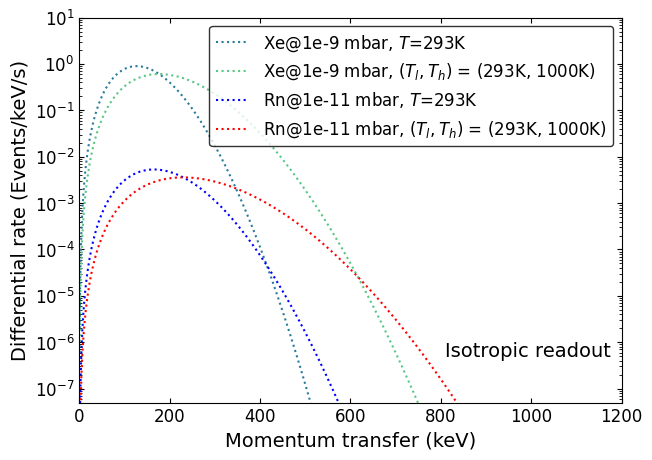

In [18]:
plt.subplots(figsize=(7, 5))
plt.plot(qq_kev, dr_dq_xe, ':', color='#2A7B9B', label='Xe@1e-9 mbar, $T$=293K')
plt.plot(qq_kev, dr_dq_diffuse_xe, ':', color='#57C785', label='Xe@1e-9 mbar, ($T_l, T_h$) = (293K, 1000K)')

plt.plot(qq_kev, dr_dq_radon, ':', color='b', label='Rn@1e-11 mbar, $T$=293K')
plt.plot(qq_kev, dr_dq_diffuse_radon, ':', color='r', label='Rn@1e-11 mbar, ($T_l, T_h$) = (293K, 1000K)')

plt.legend(edgecolor='k', fontsize=12)
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 1200)
plt.ylim(5e-8, 10)
plt.xlabel('Momentum transfer (keV)')
plt.ylabel('Differential rate (Events/keV/s)')
plt.text(810, 5e-7, 'Isotropic readout', fontsize=14)

# plt.savefig('plots/xe_isotropic_collision.pdf', dpi=600)

## Project the rate onto the z-axis

In [19]:
def get_drdqz(qq, drdq):
    drdq_iso = drdq / (4 * np.pi * qq**2)

    ret = np.empty_like(qq)
    for i, q in enumerate(qq):
        xx = qq[qq >= q]
        integrand = drdq_iso[qq >= q]

        # Another factor of two because we want rate
        # for both +z and -z
        ret[i] = 2 * 2 * np.pi * np.trapz(integrand*xx, xx)

    return qq, ret

def smear_drdqz_gauss(qq, drdqz, sigma_kev):
    """Convolve spectrum with a Gaussian kernel"""
    dq = qq[1] - qq[0]
    qq_gauss = np.arange(-2000, 2000, dq)
    gauss_kernel = gauss(qq_gauss, A=1, mu=0, sigma=sigma_kev)

    # Pad the array to minimize edge effect
    # to get the rising tail when q -> 0
    # then pad with mirror image
    pad_len = gauss_kernel.size
    if qq[0] >= dq:
        padded_drdqz = np.pad(drdqz, (pad_len, 0), mode='symmetric')
    else:
        padded_drdqz = np.pad(drdqz, (pad_len, 0), mode='reflect')
    padded_drdqz = np.pad(padded_drdqz, (0, pad_len), mode='constant', constant_values=0)

    convolved = np.convolve(padded_drdqz, gauss_kernel, mode='valid')

    idx_start = (convolved.size - drdqz.size) // 2
    ret = convolved[idx_start : idx_start + drdqz.size] / np.sum(gauss_kernel)

    return qq, ret

/var/folders/js/qsyryzx92mn4n3v5xr4_1_n40000gn/T/ipykernel_24680/325865092.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ret[i] = 2 * 2 * np.pi * np.trapz(integrand*xx, xx)


Text(0, 0.5, 'Differential rate (Events/keV/s)')

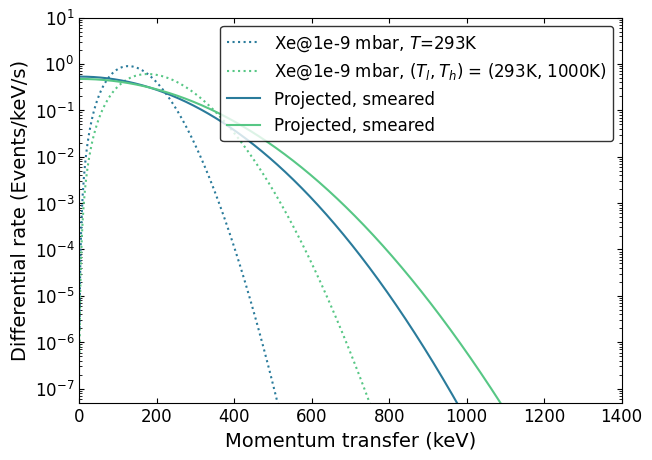

In [20]:
qqz, drdqz = get_drdqz(qq_kev, dr_dq_xe)
qqz, drdqz_diffuse = get_drdqz(qq_kev, dr_dq_diffuse_xe)

qqzn, drdqzn = smear_drdqz_gauss(qqz, drdqz, 150)
qqzn, drdqzn_diffuse = smear_drdqz_gauss(qqz, drdqz_diffuse, 150)

plt.subplots(figsize=(7, 5))
plt.plot(qq_kev, dr_dq_xe, ':', color='#2A7B9B', label='Xe@1e-9 mbar, $T$=293K')
plt.plot(qq_kev, dr_dq_diffuse_xe, ':', color='#57C785', label='Xe@1e-9 mbar, ($T_l, T_h$) = (293K, 1000K)')

# plt.plot(qqz, drdqz, '--', color='#2A7B9B', label='Projected')
# plt.plot(qqz, drdqz_diffuse, '--', color='#57C785')

plt.plot(qqzn, drdqzn, '-', color='#2A7B9B', label='Projected, smeared')
plt.plot(qqzn, drdqzn_diffuse, '-', color='#57C785', label='Projected, smeared')

plt.xlim(0, 1400)
plt.ylim(5e-8, 10)
plt.yscale('log')

plt.legend(edgecolor='k')
plt.xlabel('Momentum transfer (keV)')
plt.ylabel('Differential rate (Events/keV/s)')

# plt.savefig('plots/xe_projection.pdf', dpi=600)

In [19]:
import h5py
import os

# out_dir = r'C:\Users\yuhan\dm_nanospheres\data_processed\sphere_data'
out_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data'

outfile_name = 'sphere_20241202_recon_all_bg.h5py'
with h5py.File(os.path.join(out_dir, outfile_name), 'r') as fout:
    g = fout['recon_data_all']
    bc_0 = g['bc'][:]

    hist_all_0 = g['hist_all'][:]
    hist_det_0 = g['hist_det'][:]
    hist_det_noise_0 = g['hist_det_noise'][:]
    hist_det_noise_chi2_0 = g['hist_det_noise_chi2'][:]
    hist_det_noise_bg_0 = g['hist_det_noise_bg'][:]
    hist_det_noise_chi2_bg_0 = g['hist_det_noise_chi2_bg'][:]
    livetime_0 = g.attrs['livetime_sec']

    fout.close()

outfile_name = 'sphere_20250103_recon_all_bg.h5py'
with h5py.File(os.path.join(out_dir, outfile_name), 'r') as fout:
    g = fout['recon_data_all']
    bc_1 = g['bc'][:]

    hist_all_1 = g['hist_all'][:]
    hist_det_1 = g['hist_det'][:]
    hist_det_noise_1 = g['hist_det_noise'][:]
    hist_det_noise_chi2_1 = g['hist_det_noise_chi2'][:]
    hist_det_noise_bg_1 = g['hist_det_noise_bg'][:]
    hist_det_noise_chi2_bg_1 = g['hist_det_noise_chi2_bg'][:]
    livetime_1 = g.attrs['livetime_sec']

    fout.close()

amp2kev_sphere_20241202 = 5945.245097647231
amp2kev_sphere_20250103 = 5923.2059527417405
file0 = h5py.File(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data/sphere_20241202_unbinned_amps_bg.h5py')
file1 = h5py.File(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data/sphere_20250103_unbinned_amps_bg.h5py')

amps0 = file0['unbinned_amps']['amplitude'][:]
amps1 = file1['unbinned_amps']['amplitude'][:]
file0.close()
file1.close()

amps_kev_0 = np.abs(amps0 * amp2kev_sphere_20241202)
amps_kev_1 = np.abs(amps1 * amp2kev_sphere_20250103)

In [ ]:
qqzn, drdqzn = smear_drdqz_gauss(qqz, drdqz, 200)
qqzn, drdqzn_diffuse = smear_drdqz_gauss(qqz, drdqz_diffuse, 200)

plt.errorbar(bc_1, hist_det_noise_chi2_bg_1/livetime_1,
             yerr=np.sqrt(hist_det_noise_chi2_bg_1)/(livetime_1), fmt='.', color='#005AB5', label='Nanosphere 2')
# plt.plot(qqzn, 50*drdqzn*1000, '-', color='#2A7B9B', label='Xe@1e-8 mbar, $T$=293K')
plt.plot(qqzn, 50*drdqzn, '-', color='#2A7B9B', label='Xe@1e-9 mbar, $T$=293K')
# plt.plot(qqzn, 50*drdqzn_diffuse*1000, '-', color='#57C785', label='Xe@1e-8 mbar, ($T_l, T_h$) = (293K, 1000K)')
plt.plot(qqzn, 50*drdqzn_diffuse, '-', color='#57C785', label='Xe@1e-9 mbar, ($T_l, T_h$) = (293K, 1000K)')

xx = np.linspace(0, 2500)

sig = 200
half_gauss_amp = 50 * 2 * np.sum(hist_det_noise_chi2_bg_1/livetime_1) / (sig * np.sqrt(2 * np.pi))
plt.plot(xx, gauss(xx, half_gauss_amp, 0, sig), ':', color='#FD1D1D', label=r'$\sigma_p=$200 keV')

# sig = 150
# half_gauss_amp = 50 * 2 * np.sum(hist_det_noise_chi2_bg_1/livetime_1) / (sig * np.sqrt(2 * np.pi))
# plt.plot(xx, gauss(xx, half_gauss_amp, 0, sig), ':', color='#FD6430', label=r'$\sigma_p=$150 keV')

# sig = 100
# half_gauss_amp = 50 * 2 * np.sum(hist_det_noise_chi2_bg_1/livetime_1) / (sig * np.sqrt(2 * np.pi))
# plt.plot(xx, gauss(xx, half_gauss_amp, 0, sig), ':', color='#FCB045', label=r'$\sigma_p=$100 keV')

plt.ylim(5e-8, 1e4)
plt.xlim(0, 4500)

plt.yscale('log')

plt.legend(edgecolor='k', fontsize=10, loc='upper right')
plt.xlabel('Momentum transfer (keV)', fontsize=14)
plt.ylabel('Events/(50 keV)/s', fontsize=14)

# plt.savefig('plots/xe_projected_wsphere.pdf', dpi=600)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(4, 8))

qqzn, drdqzn = smear_drdqz_gauss(qqz, drdqz, 150)
qqzn, drdqzn_diffuse = smear_drdqz_gauss(qqz, drdqz_diffuse, 150)

# axes[0].plot(qqzn, 50*drdqzn*1000, '-', color='#2A7B9B')
axes[0].plot(qqzn, 50*drdqzn, '-', color='#2A7B9B')
# axes[0].plot(qqzn, 50*drdqzn_diffuse*1000, '-', color='#57C785')
axes[0].plot(qqzn, 50*drdqzn_diffuse, '-', color='#57C785')

xx = np.linspace(0, 2500)

sig = 150
half_gauss_amp = 50 * 2 * np.sum(hist_det_noise_chi2_bg_1/livetime_1) / (sig * np.sqrt(2 * np.pi))
axes[0].plot(xx, gauss(xx, half_gauss_amp, 0, sig), ':', color='#FD6430', label=r'$\sigma_p=$150 keV')

qqzn, drdqzn = smear_drdqz_gauss(qqz, drdqz, 100)
qqzn, drdqzn_diffuse = smear_drdqz_gauss(qqz, drdqz_diffuse, 100)

# axes[1].plot(qqzn, 50*drdqzn*1000, '-', color='#2A7B9B')
axes[1].plot(qqzn, 50*drdqzn, '-', color='#2A7B9B')
# axes[1].plot(qqzn, 50*drdqzn_diffuse*1000, '-', color='#57C785')
axes[1].plot(qqzn, 50*drdqzn_diffuse, '-', color='#57C785')

sig = 100
half_gauss_amp = 50 * 2 * np.sum(hist_det_noise_chi2_bg_1/livetime_1) / (sig * np.sqrt(2 * np.pi))
plt.plot(xx, gauss(xx, half_gauss_amp, 0, sig), ':', color='#FCB045', label=r'$\sigma_p=$100 keV')

for ax in axes:
    ax.set_ylim(5e-8, 1e4)
    ax.set_xlim(0, 2500)
    ax.set_yscale('log')
    ax.legend(edgecolor='k', fontsize=10, loc='upper right')
    ax.set_ylabel('Events/(50 keV)/s', fontsize=14)


plt.xlabel('Momentum transfer (keV)', fontsize=14)